<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Exploration**

In this notebook we unpack [RAFT](https://arxiv.org/pdf/2003.12039.pdf) or Recurrent All-Pairs Field Transforms for Optical Flow. We will learn the inner workings of it as well as how to implement it to compute optical flow.

<br>

### **What is Optical Flow?**
Optical Flow is the apparent per-pixel motion between video frames. Optical Flow has two main categories: sparse and dense. Sparse optical flow tracks the velocity of a set of feature points, dense optical flowtracks the apparent motion of all pixels. RAFT is a deep neural network that is able to estimate the dense optical flow between two video frames. An example is shown below:


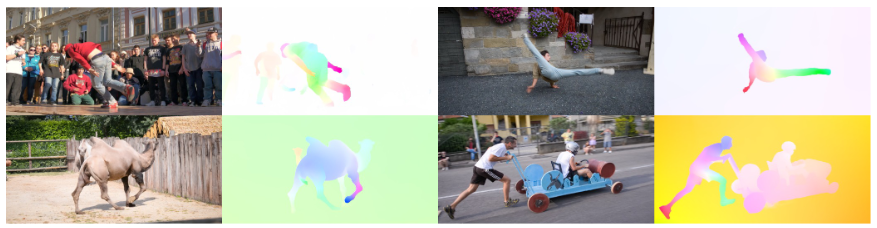

In the example, the relative motion has been color coded for visibility, but in general a model like RAFT will estimate an (x,y) vector of motion.


# **Motivation**

A common method for computing Dense Optical Flow is to use [Farenbeck's method](https://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) which fits a 2nd order polynomial to the apparent flow. It is readily implemented in [opencv](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html). However, it is not very fast and involves parameter tuning that is dependent on the domain. RAFT provides a different approach that could be faster with less domain dependent parameter tuning.

Optical Flow estimation is challenged by: fast moving objects, motion blur, Occlusions, and lack of texture. Hand designing a method to include all of these corner cases is difficult.

Clone the repo and import libraries

In [2]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 1 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [3]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Add RAFT core to path

In [4]:
sys.path.append('RAFT/core')

Get demo frames

In [5]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread(os.path.join(demo_path, 'frame_0020.png'))
frame2 = cv2.imread(os.path.join(demo_path, 'frame_0021.png'))

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

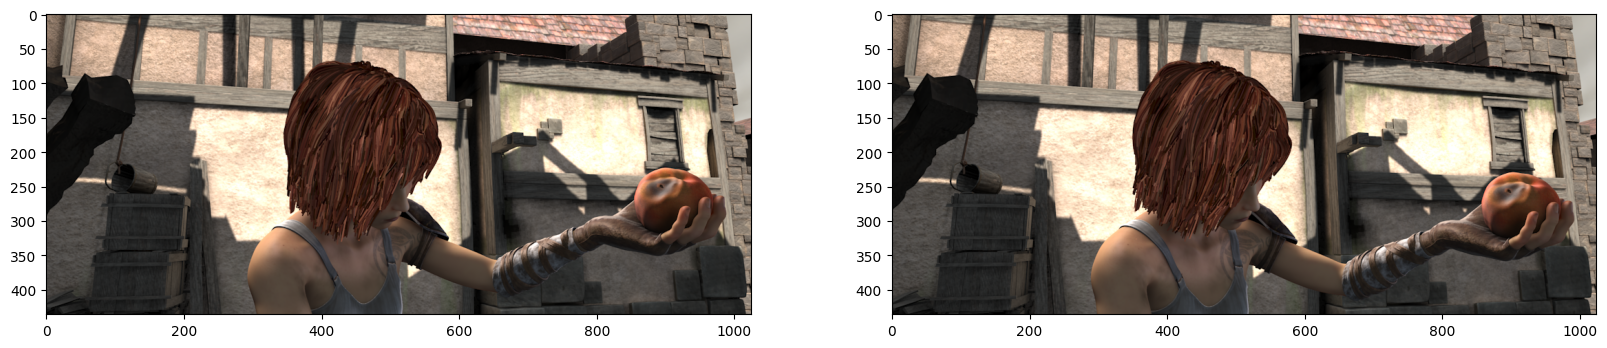

In [6]:
_, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].imshow(frame1)
ax[1].imshow(frame2);

## Download models

In [7]:
%cd RAFT
!./download_models.sh
# !python demo.py --model=models/raft-things.pth --path=demo-frames
%cd ..

/content/RAFT
--2023-09-04 23:33:41--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:6031:15::a27d:510f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.81.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  12.7MB/s    in 7.7s    

2023-09-04 23:33:51 (10.2 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
/content


### Helper functions

In [78]:
from collections import OrderedDict
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)



          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
  def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

### Load Model

In [68]:
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

### Predict Optical Flow

In [74]:
flow_low, flow_up = inference(model, frame1, frame2, device='cuda')

In [75]:
flow_low.shape, flow_up.shape

(torch.Size([1, 2, 55, 128]), torch.Size([1, 2, 440, 1024]))

### Display Results

In [70]:
flow_low_viz = get_viz(flow_low)
flow_up_viz = get_viz(flow_up)

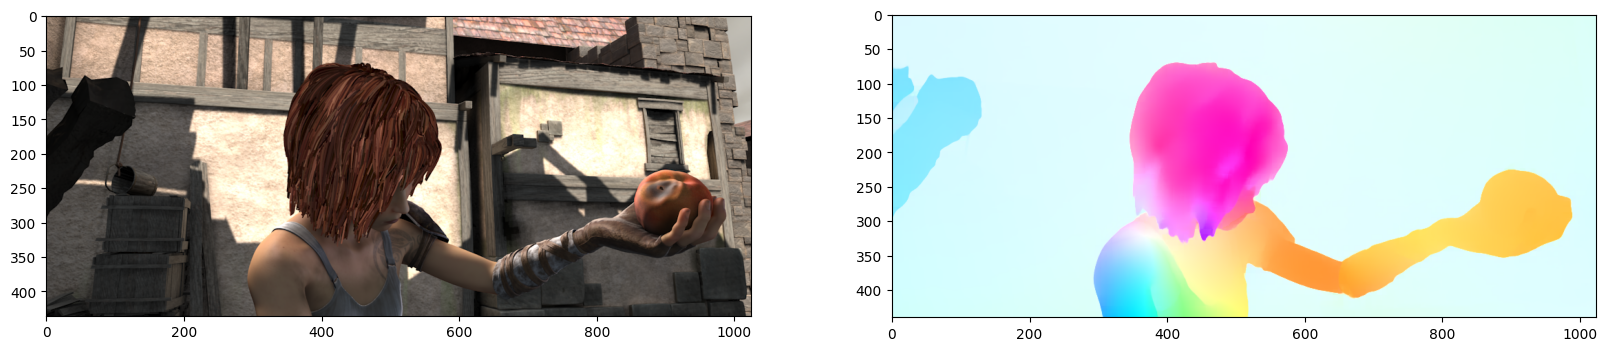

In [81]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(frame1)
ax1.imshow(flow_up_viz)
plt.show()

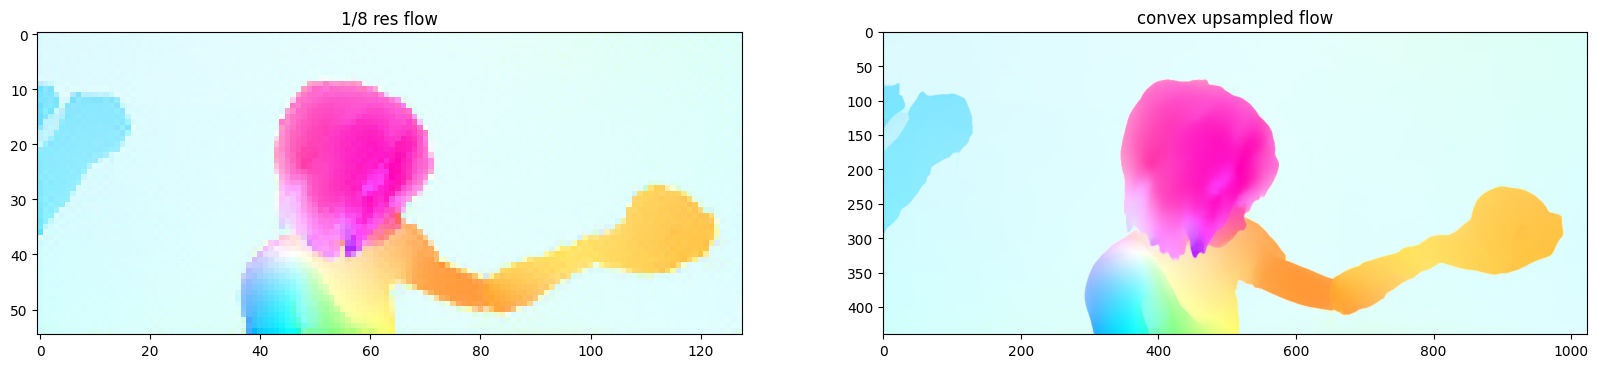

In [77]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(flow_low_viz)
ax0.set_title('1/8 res flow')
ax1.imshow(flow_up_viz)
ax1.set_title('convex upsampled flow');

In [79]:
flow_iters = inference(model, frame1, frame2, device='cuda', test_mode=False)

In [80]:
len(flow_iters)

12

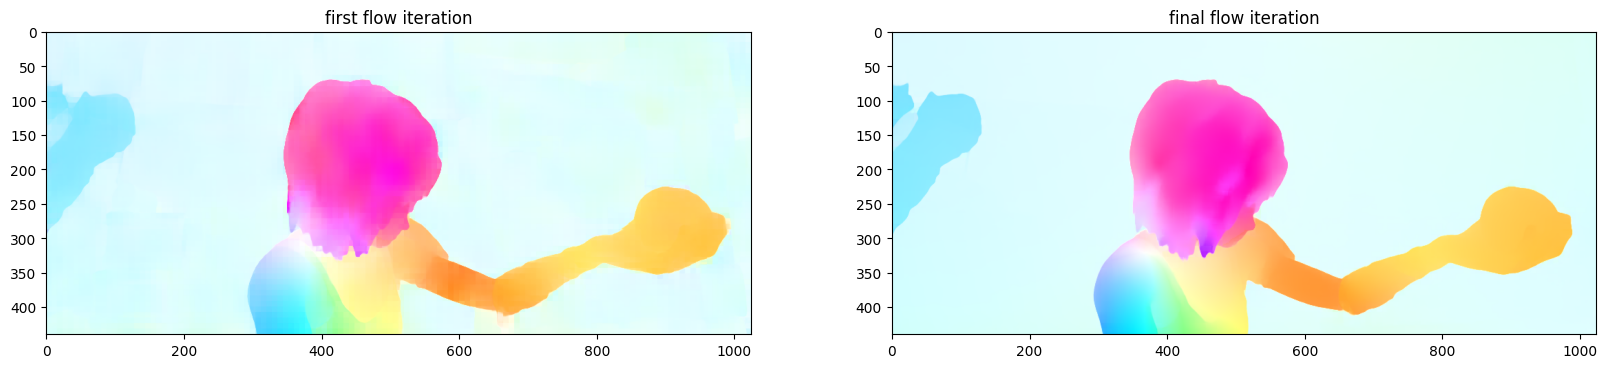

In [82]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

## Try an example on Kitti

We can either use the KITTI website to download, or select a video sequence from the MOT challenge.

In [ ]:
!wget https://motchallenge.net/sequenceVideos/KITTI-16-raw.webm

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_29_drive_0071/2011_09_29_drive_0071_sync.zip
!jar xf /content/2011_09_29_drive_0071_sync.zip

In [126]:
cap = cv2.VideoCapture("KITTI-16-raw.webm")

if (cap.isOpened() == False):
    print("Error opening video file")

fps = cap.get(cv2.CAP_PROP_FPS)
frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:

        # save to list
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

In [170]:
from glob import glob

left_image_paths = sorted(glob('/content/2011_09_29/2011_09_29_drive_0071_sync/image_02/data/*.png'))
frames = [cv2.imread(path) for path in left_image_paths]

In [171]:
len(frames)

1059

In [182]:
idx = 75
frame1 = frames[idx]
frame2 = frames[idx + 1]

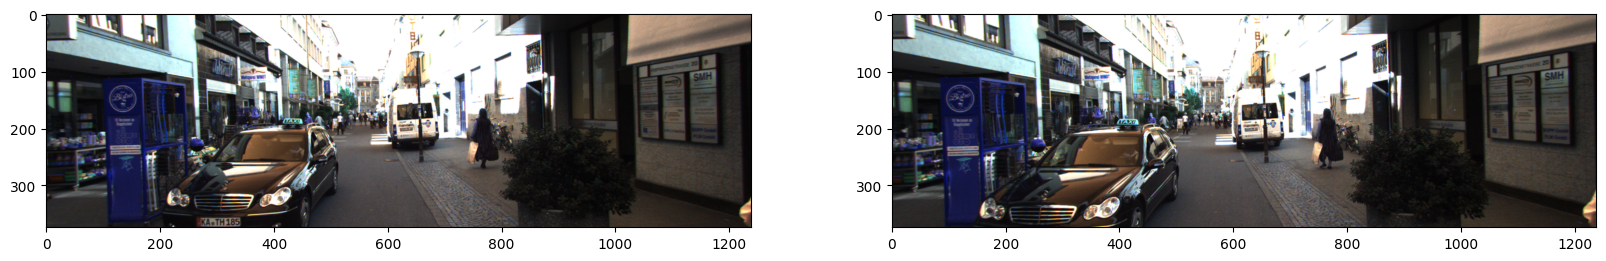

In [183]:
_, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].imshow(frame1)
ax[1].imshow(frame2);

In [184]:
# del model
model = load_model("RAFT/models/raft-kitti.pth", args=Args())
flow_iters = inference(model, frame1, frame2, device='cuda', pad_mode='kitti', iters=20, test_mode=False)
# flow_iters = inference(model, cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR), cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR), device='cuda', pad_mode='kitti', iters=20, test_mode=False)

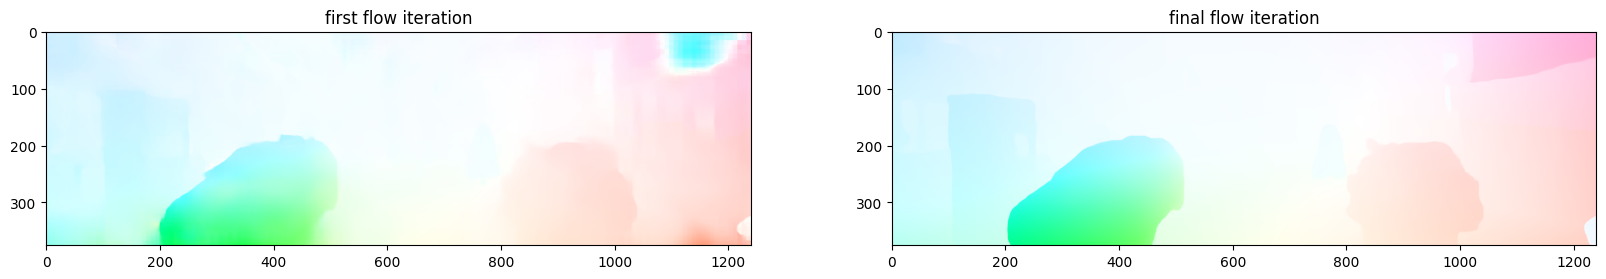

In [185]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');